In [1]:
from mma import *
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from multipers import *
from joblib import Parallel, delayed
from multiprocessing import Pool, Manager, cpu_count
from sklearn.neighbors import KernelDensity
from joblib import parallel_backend
from numpy.polynomial.polynomial import polyfit
from benchmark_functions import *
from pandas import read_csv
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from multipers import *

In [2]:
dataset = "Coffee"
def get_dataset(dataset = "Coffee"):
    dataset_path = "./UCR/" + dataset + "/" + dataset + "_TRAIN.tsv"
    data = np.array(read_csv(dataset_path, delimiter='\t', header=None, index_col=0))
    return data
data = get_dataset(dataset)

In [4]:
tde = TimeDelayEmbedding().transform(data)
X = tde[0]
simplex_tree = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=0.01)
print(simplex_tree.num_simplices())
nsimp = simplex_tree.num_simplices()
kde = KernelDensity(kernel='gaussian', bandwidth=.3).fit(X)
density = -np.array(kde.score_samples(X))
alpha = [simplex_tree.filtration(s) for s,_ in simplex_tree.get_simplices()]
boundary, filters = ls_boundary_density(simplex_tree, [alpha, density], [0])


# list_splx = simplex_tree.get_filtration()
# subdivision = barycentric_subdivision(simplex_tree)
# filtration_rips = np.array([subdivision.filtration(s) for s,_ in subdivision.get_skeleton(0)])[:,None]
# for s,_ in simplex_tree.get_filtration():
#     if len(s) == 1:
#         simplex_tree.assign_filtration(s, -density[s[0]])
#     else:
#         simplex_tree.assign_filtration(s, -1e10)
# simplex_tree.make_filtration_non_decreasing()
# subdivision = barycentric_subdivision(simplex_tree, list_splx)
# filtration_dens = np.array([subdivision.filtration(s) for s,_ in subdivision.get_skeleton(0)])[:,None]
# filtration = np.hstack([filtration_rips, filtration_dens])
# box = [[min(filtration[:,0]),min(filtration[:,1])],[max(filtration[:,0]),max(filtration[:,1])]]
# boundary = simplextree_to_sparse_boundary(subdivision)


box = [[0,0], [1,2]]
weird_box = [0,1,0,2]
nlines = 300
precision = 3/nlines
barcodes =vine_alt(boundary, filters, precision, box)

2743


In [5]:
base_images = [multipersistence_image(
    convert_barcodes(barcodes[i]),
    bnds=weird_box,
    bandwidth = precision
)
              for i in range(len(barcodes))]

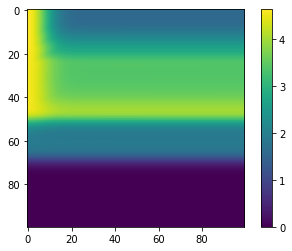

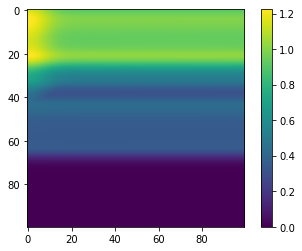

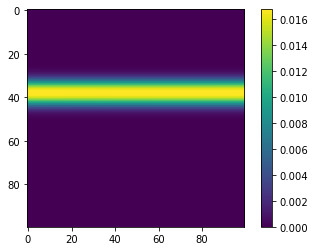

In [6]:
## Save persistence images 
for i in range(len(barcodes)):
    plt.imshow(np.flip(base_images[i],0))
    plt.colorbar()
    plt.savefig(dataset + "_nline_"+str(nlines) + "_H" + str(i) + "_precision_"+str(precision)+".svg")
    plt.show()


In [7]:
num = 20
set_of_nlines = np.linspace(start=100, stop = nlines, num=num)
error = np.empty((len(set_of_nlines), len(barcodes)))
for n in range(len(set_of_nlines)):
    precision = 3 / set_of_nlines[n]
    barcodes = vine_alt(boundary, filters, precision,box, threshold = 1);
    for dim in range(len(barcodes)):
        bc = convert_barcodes(barcodes[dim])
        image = multipersistence_image(bc,bnds = weird_box, bandwidth = 3/nlines)
        error[n,dim]=np.linalg.norm(base_images[dim]-image)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
for i in range(len(barcodes)):
    plt.plot(set_of_nlines, error[:,i], label="H{}".format(i))
# plt.plot(set_of_nlines[10:], error[10:,0], label="H{}".format(0))
# plt.plot(set_of_nlines[10:], error[10:,2], label="H{}".format(2))
plt.xlabel("Number of lines")
plt.ylabel("Error norm")
plt.legend()
plt.savefig("UCR_"+dataset+"_image_error_nlines_"+str(nlines)+".svg")
plt.show()